# Read file trim-sc_fl_03_2021.nc

In [1]:
import pooch


url = f"https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.0.1.dev"

sc_fl_08_2021 = pooch.retrieve(
    url=f"{url}/{version}/trim-sc_fl_08_2021.nc",
    known_hash="sha256:bb259b49516b7575914003d69128aae1ed40ba57b7e8b9b7df715fb4eccf888f",
)

In [2]:
import cf_xarray
import xarray as xr


ds = xr.open_dataset(sc_fl_08_2021, drop_variables="time_bounds")

In [3]:
ds

<xarray.Dataset>
Dimensions:      (time: 745, m: 181, n: 218, Layer: 8, LayerInterf: 9)
Coordinates:
  * time         (time) datetime64[ns] 2021-08-01 ... 2021-09-01
  * m            (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.1 -47.09 -47.09
  * n            (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
    longitude    (m, n) float32 ...
    latitude     (m, n) float32 ...
  * Layer        (Layer) float32 -0.0625 -0.1875 -0.3125 ... -0.8125 -0.9375
  * LayerInterf  (LayerInterf) float32 0.0 -0.125 -0.25 ... -0.75 -0.875 -1.0
Data variables:
    depth        (m, n) float32 ...
    waterlevel   (time, m, n) float32 ...
    velocity_x   (time, Layer, m, n) float32 ...
    velocity_y   (time, Layer, m, n) float32 ...
Attributes: (12/24)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Original filename: trim-sc_fl_08_2021.dat,...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_max:            -47.08960398561253
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down

In [4]:
print(f"Start: {ds.cf['T'][0].to_numpy()}\nEnd: {ds.cf['T'][-1].to_numpy()}")

Start: 2021-08-01T00:00:00.000000000
End: 2021-09-01T00:00:00.000000000


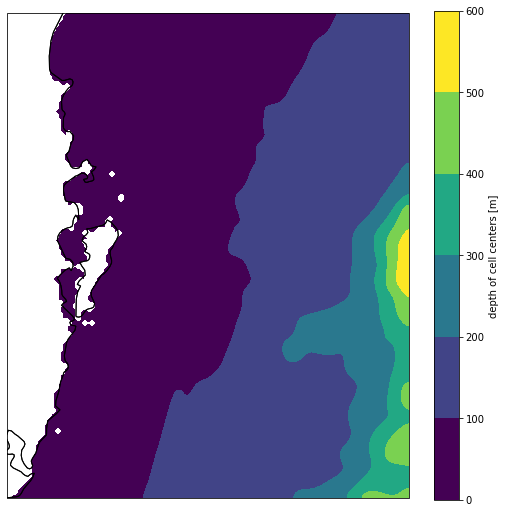

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        }
    )
    if bbox:
        ax.set_extent(bbox)
    ax.coastlines(resolution="10m")
    return fig, ax

fig, ax = creat_map()
ds.cf["sea_floor_depth_below_sea_level"].T.plot.contourf(ax=ax)
ax.coastlines();

Let's check the first layer of the first day.

We need to convert the `ocean_sigma_coordinate` coordinate there to z later!

In [6]:
import numpy as np


def normalize_speed(u, v):
    u_norm = u / np.sqrt(u ** 2.0 + v ** 2.0)
    v_norm = v / np.sqrt(u ** 2.0 + v ** 2.0)
    speed = (u ** 2 + v ** 2) ** 0.5
    return (u_norm, v_norm, speed)

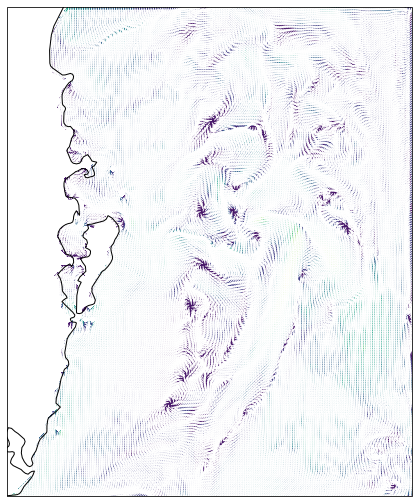

In [7]:
subset = ds.sel({"time": "2021-08-01T00:00:00"}).isel({"Layer": 0})

bbox = subset["m"].min(), subset["m"].max(), subset["n"].min(), subset["n"].max()
bbox = [v.to_numpy() for v in bbox]

u = subset.cf["eastward_sea_water_velocity"].squeeze()
v = subset.cf["northward_sea_water_velocity"].squeeze()

u_norm, v_norm, speed = normalize_speed(u, v)

fig, ax = creat_map(bbox=bbox)
ax.contourf(subset["longitude"], subset["latitude"], speed)
ax.quiver(subset["longitude"], subset["latitude"], u_norm, v_norm, color="white", scale=50);

In [8]:
def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        }
    )
    if bbox:
        ax.set_extent(bbox)
    ax.coastlines(resolution="10m")
    return fig, ax

In [9]:
def convert_npdatetime2str(npdatetime):
    import pandas as pd
    ts = pd.to_datetime(str(npdatetime))
    return ts.strftime("%Y-%m-%d %H:%M:%S")

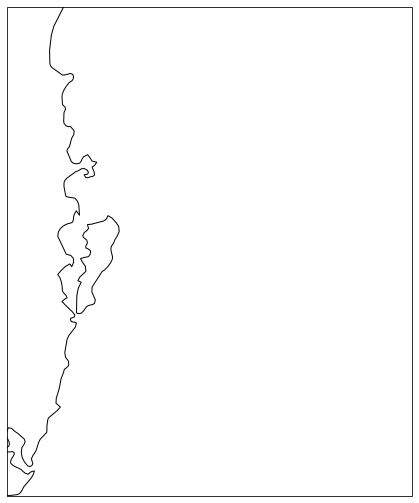

In [10]:
fig, ax = creat_map(bbox=bbox, figsize=(9, 9));

In [11]:
from xmovie import Movie


def custom_plot_function(ds, fig, tt, *args, **kwargs):
    ax = fig.gca()
    vmin, vmax =-1.5, 1.9  # Data min/max but we will less to highligh the tides inside the bays.
    ds.isel(time=tt).plot(ax=ax, vmin=-0.5, vmax=0.5, cmap="RdBu_r")

    npdatetime = ds["time"][tt].to_numpy()
    title = convert_npdatetime2str(npdatetime)
    ax.set_title(title)
    return None, None


chunked = ds.cf["sea_surface_height"].T.chunk({'time':1})
mov = Movie(chunked, custom_plot_function)

/home/filipe/micromamba/envs/PARCELS/lib/python3.10/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/filipe/micromamba/envs/PARCELS/lib/python3.10/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


## Check first time steps

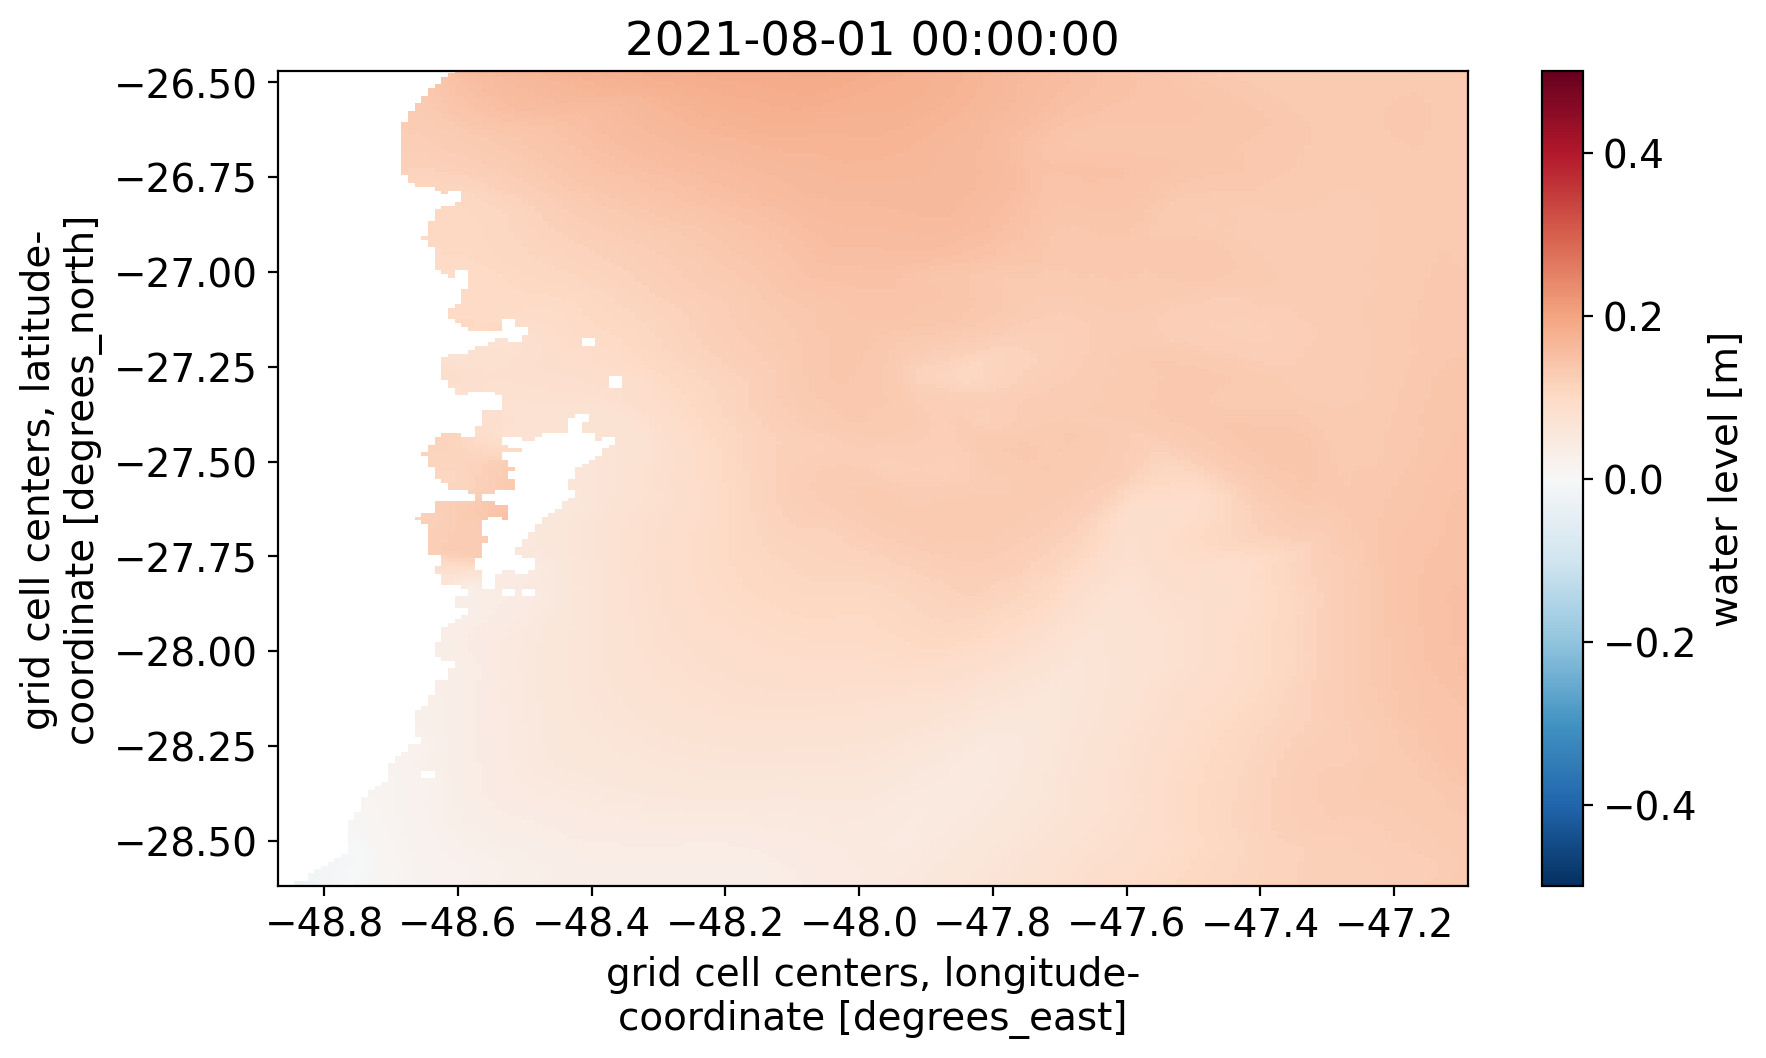

In [12]:
mov.preview(0)  # first hour

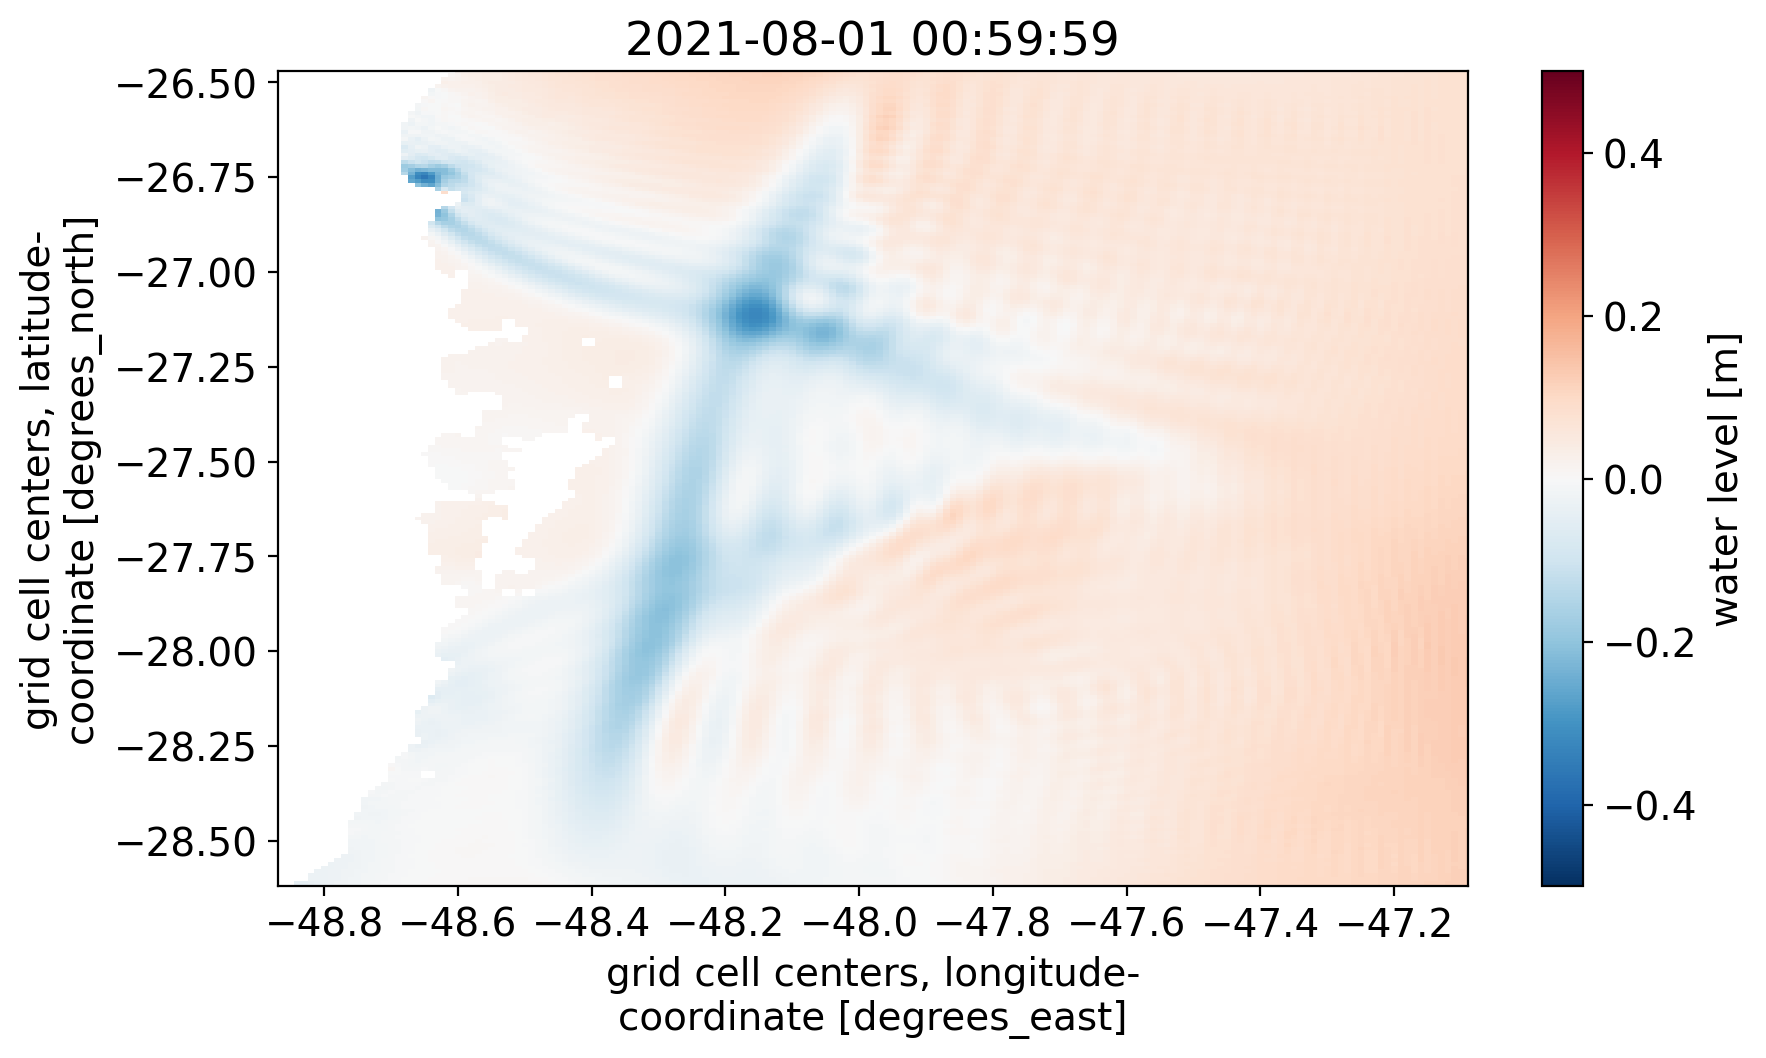

In [13]:
mov.preview(1)  # second hour

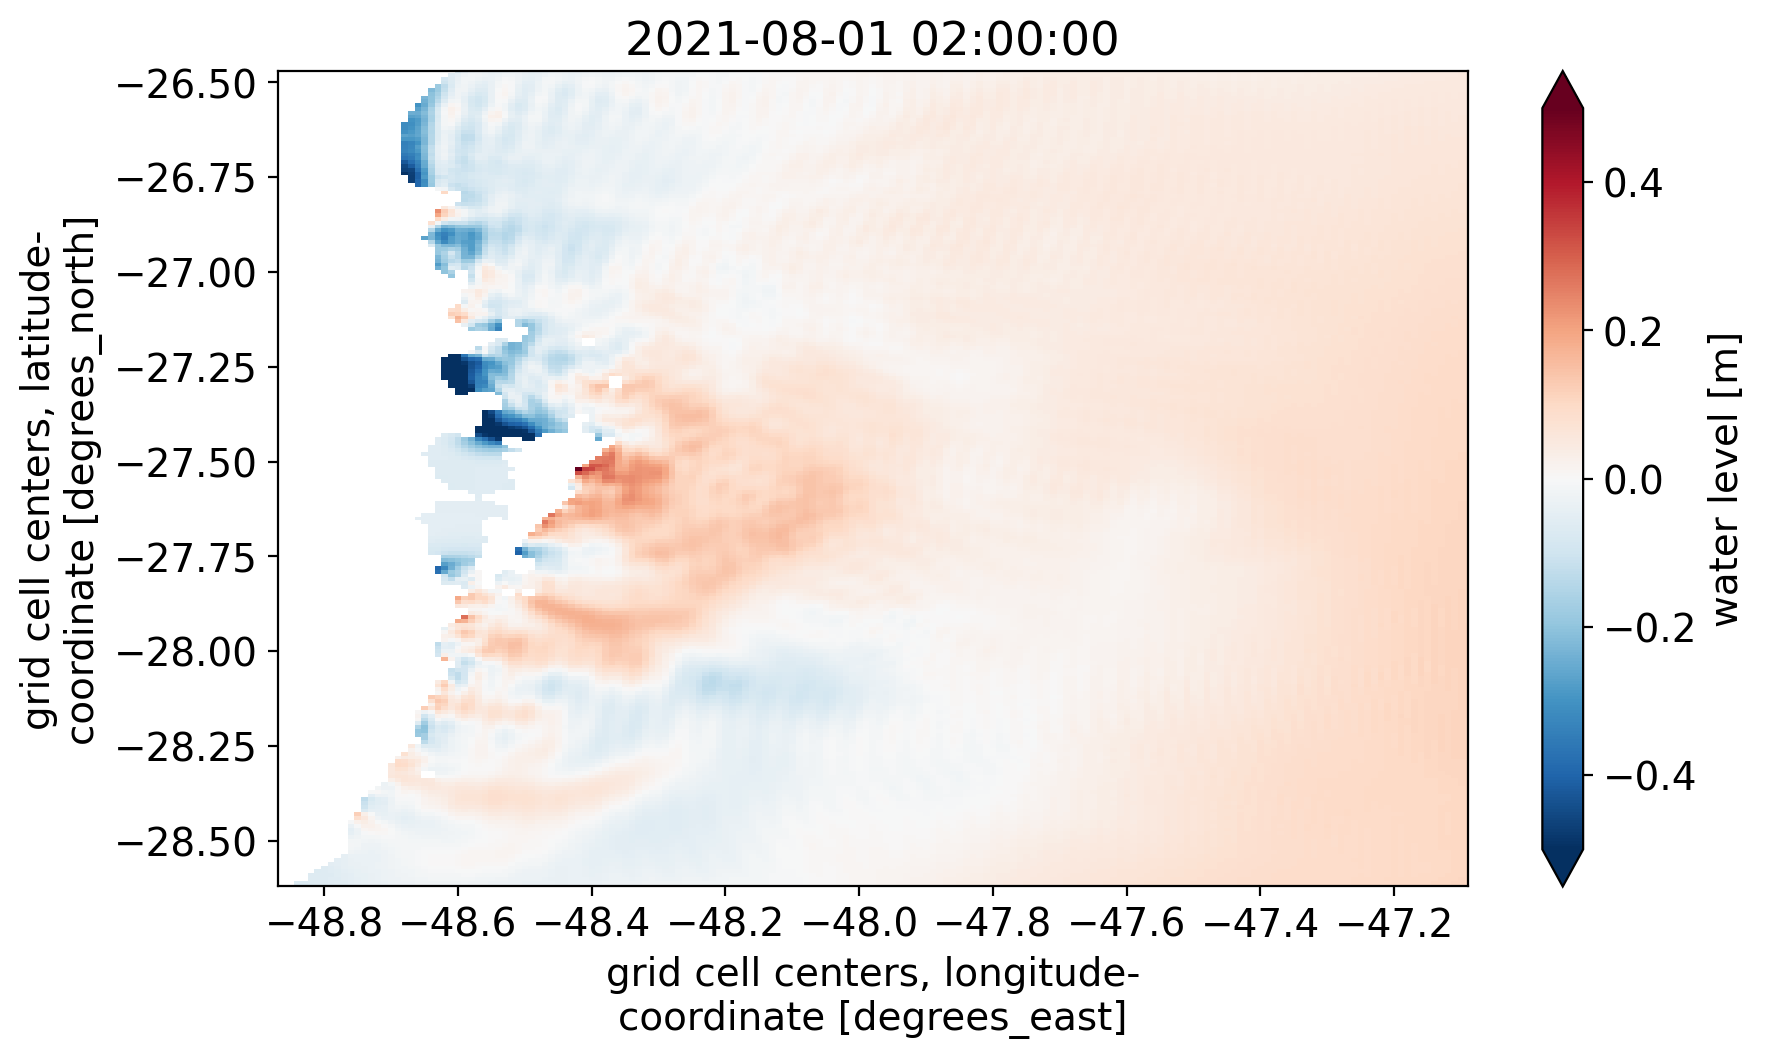

In [14]:
mov.preview(2)  # third hour

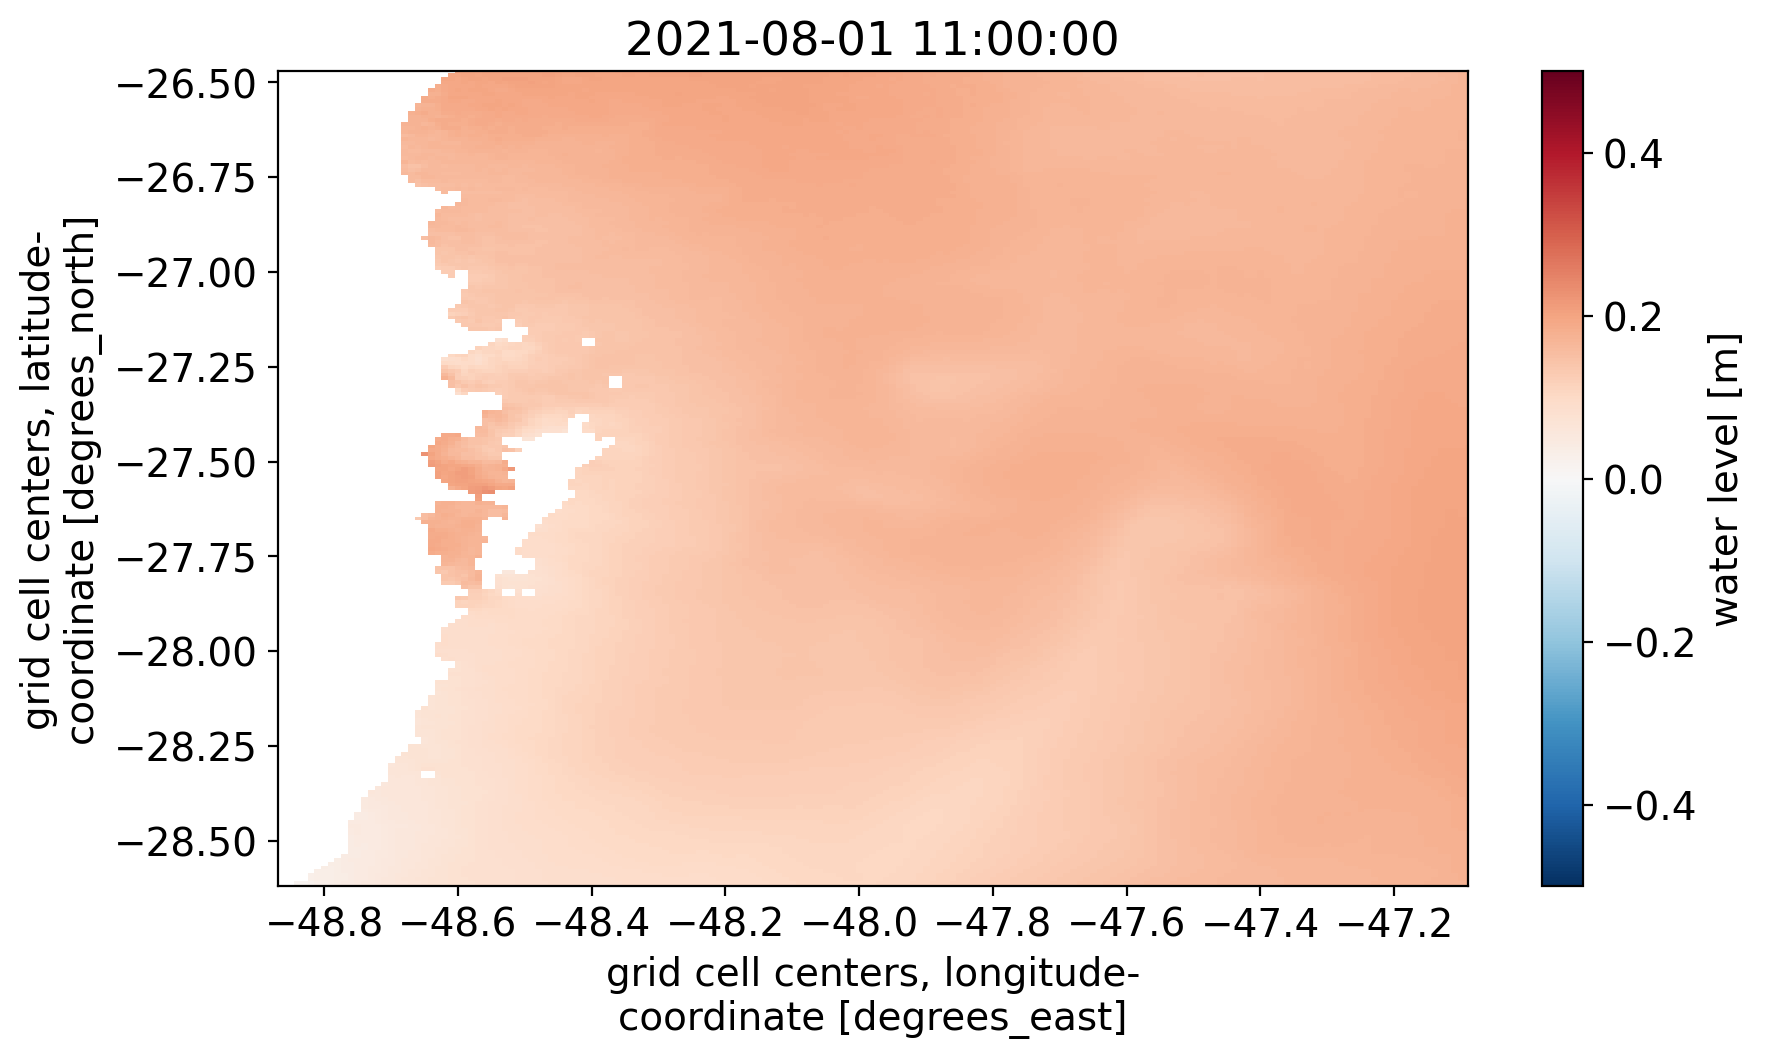

In [15]:
mov.preview(11)  # twelfth hour

## Render movie

In [16]:
filename = "sc_fl_08_2021-ssh.mp4"


mov.save(
    filename=filename,
    progress=True,
    parallel=True,
    parallel_compute_kwargs={"scheduler": "processes", "num_workers": 3},
    overwrite_existing=True,
)

Movie created at sc_fl_08_2021-ssh.mp4


In [17]:
from IPython.display import HTML


HTML(f"""
    <video alt="test" controls style="outline:none; width:70%; height:70%;">
        <source src="{filename}" type="video/mp4">
    </video>
""")